# Step2 NBRA NA-MD with Quantum Espresso

In [3]:
from liblibra_core import *
from libra_py import *
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

In [4]:
scf_inp = \
"""&CONTROL
  calculation   = 'scf',
  pseudo_dir    = '/util/academic/espresso/6.2.1/pseudopotentials/upf_files/',
  outdir        = './',
  prefix        = 'x0',
  disk_io       = 'low',
/

&SYSTEM
  ibrav       = 0,
  nat         = 25,
  ntyp        = 4,
  nspin       = 1,
  nbnd        = 50
  ecutwfc     = 30,
  ecutrho     = 300,
  occupations = 'smearing',
  smearing    = 'gaussian',
  degauss     = 0.01,
  nosym       = true,
/

&ELECTRONS
  electron_maxstep = 300,
  conv_thr         = 1.D-4,
  mixing_beta      = 0.30,
/

ATOMIC_SPECIES
C  12.010     C.pbe-n-rrkjus_psl.0.1.UPF 
H  1.007      H.pbe-rrkjus_psl.0.1.UPF 
Ir 192.217    Ir.pbe-n-rrkjus_psl.0.2.3.UPF
N  14.006     N.pbe-n-rrkjus_psl.0.1.UPF

K_POINTS gamma

CELL_PARAMETERS  angstrom
        7.0652699470        0.0000000000         0.0000000000
        0.0000000000        7.0652699470         0.0000000000
        0.0000000000        0.0000000000         7.0652699470 

"""

In [5]:
exp_inp = \
"""&inputpp
  prefix      = 'x0',
  outdir      = './',
  pseudo_dir  = '/util/academic/espresso/6.2.1/pseudopotentials/upf_files',
  psfile(1) =  C.pbe-n-rrkjus_psl.0.1.UPF 
  psfile(2) =  H.pbe-rrkjus_psl.0.1.UPF
  psfile(3) =  Ir.pbe-n-rrkjus_psl.0.2.3.UPF
  psfile(4) =  N.pbe-n-rrkjus_psl.0.1.UPF
  single_file = .FALSE.,
  ascii       = .TRUE.,
  uspp_spsi   = .FALSE.,
/
"""

In [6]:
submit_inp = \
"""#!/bin/sh
#SBATCH --partition=valhalla --qos=valhalla
#SBATCH --cluster=faculty
###SBATCH --partition=scavenger --qos=scavenger
###SBATCH --cluster=faculty
###SBATCH --requeue
#SBATCH --time=6:00:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=12
#SBATCH --mem=20000
#SBATCH --mail-user=bsmith24@buffalo.edu

echo "SLURM_JOBID="$SLURM_JOBID
echo "SLURM_JOB_NODELIST="$SLURM_JOB_NODELIST
echo "SLURM_NNODES="$SLURM_NNODES
echo "SLURMTMPDIR="$SLURMTMPDIR
echo "working directory="$SLURM_SUBMIT_DIR

NPROCS=`srun --export=ALL --nodes=${SLURM_NNODES} bash -c 'hostname' |wc -l`
echo NPROCS=$NPROCS

module load espresso/6.2.1

#The PMI library is necessary for srun
export I_MPI_PMI_LIBRARY=/usr/lib64/libpmi.so

# Setup all manual parameters here
# Must be ABSOLUTE paths
NP=12
exe_qespresso=/util/academic/espresso/6.2.1/bin/pw.x
exe_export=/util/academic/espresso/6.2.1/bin/pw_export.x
exe_convert=/util/academic/espresso/6.2.1/bin/iotk
batch_system="srun --export=All"
res=$PWD/../../res

# These will be assigned automatically, leave them as they are
param1=
param2=

# This is invocation of the scripts which will further handle NA-MD calclculations
# on the NAC calculation step
# NOTE: minband - starting from 1
#       maxband - is included

python -c "from libra_py.workflows.nbra import step2
params = { }
params[\\"BATCH_SYSTEM\\"]=\\"$batch_system\\"
params[\\"NP\\"]=$NP
params[\\"EXE\\"]=\\"$exe_qespresso\\"
params[\\"EXE_EXPORT\\"]=\\"$exe_export\\"
params[\\"EXE_CONVERT\\"] =\\"$exe_convert\\"
params[\\"start_indx\\"]=\\"$param1\\"
params[\\"stop_indx\\"]=\\"$param2\\"
params[\\"wd\\"]=\\"wd\\"
params[\\"rd\\"]=\\"$res\\"
params[\\"dt\\"]=41.34145
params[\\"minband\\"]=20
params[\\"maxband\\"]=50
params[\\"minband_soc\\"]=20
params[\\"maxband_soc\\"]=50
params[\\"nac_method\\"]=0
params[\\"orthogonalize\\"]=1
params[\\"prefix0\\"]=\\"x0.scf\\"
params[\\"compute_Hprime\\"]=0
params[\\"verbosity\\"]=1
print( params )
step2.run(params)
"
"""


In [7]:
run_step2_inp = \
"""import os
import sys
import time
import math

# Fisrt, we add the location of the library to test to the PYTHON path
if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import *

# Remove the previous results and temporary working directory from the previous runs
os.system("rm -r res")
os.system("rm -r wd")
os.system("mkdir res")

tot_nsteps     = 100
nsteps_per_job = 10
# tot_nsteps = total simulation time (from 0!)
# tot_nsteps / nsteps_per_job = total number of jobs submitted

# For non-SOC
QE_methods.out2inp("x0.md.out","x0.scf.in","wd","x0.scf",0,tot_nsteps,1)
os.system("cp submit_templ.slm wd"); os.system("cp x0.exp.in wd"); os.chdir("wd")
hpc_utils.distribute(0,tot_nsteps,nsteps_per_job,"submit_templ.slm",["x0.exp.in"],["x0.scf"],2)

#For SOC
#QE_methods.out2inp("x0.md.out","x1.scf.in","wd","x1.scf",0,tot_nsteps,1)
#os.system("cp submit_templ.slm wd"); os.system("cp x1.exp.in wd"); os.chdir("wd")
#hpc_utils.distribute(0,tot_nsteps,nsteps_per_job,"submit_templ.slm",["x1.exp.in"],["x1.scf"],2)
"""

In [8]:
#!cp ../../step1/x0.md.out .
f = open("x0.scf.in","w")
f.write(scf_inp)
f.close()
f = open("x0.exp.in","w"); f.write(exp_inp); f.close()
f = open("submit_templ.slm","w"); f.write(submit_inp); f.close()
f = open("run_step2.py","w"); f.write(run_step2_inp); f.close()

In [9]:
!python run_step2.py

/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

In [6]:
import os
cwd = os.getcwd()
num_alpha_ks_orbs = 31
data_dim    = 2*num_alpha_ks_orbs
act_sp      = range(data_dim)
res_dir     = cwd+"/res/"
dt          = 1.0*units.fs2au
start_time  = 0
finish_time = 99
params = { "data_set_paths" : [res_dir],
           "active_space":act_sp,  "dt":dt, "data_dim":data_dim,
           "isnap":start_time,  "fsnap":finish_time,
           "data_re_prefix" : "hvib_dia_", "data_re_suffix" : "_re",
           "data_im_prefix" : "hvib_dia_", "data_im_suffix" : "_im",
         }

print ("\nGathering the data ...")
start = time.time()
Hvib_ks = data_read.get_data_sets(params)
end = time.time()
print ("Complete")
print ("Time to complete: ", end - start)


Gathering the data ...
Complete
Time to complete:  0.884307861328125


In [7]:
ntraj  = len(Hvib_ks)
nsteps = len(Hvib_ks[0])
ks_res = data_stat.cmat_stat2(Hvib_ks[0], 2)

In [8]:
ks_tNACs = []
ks_orbs_to_print = range(int(data_dim/2)) 
#ks_orbs_to_print = range(int(data_dim/2), data_dim)
#ks_orbs_to_print = range(data_dim)
md_time = list(range(nsteps))

KS_energy = []
for ks_index in range( num_alpha_ks_orbs ):
    KS_energy.append( [] )
    for step in range( nsteps ):
        #print( Hvib_ks[ 0 ][ step ].get( ks_index, ks_index ).real )
        KS_energy[ ks_index ].append( Hvib_ks[ 0 ][ step ].get( ks_index, ks_index ).real )
        
for i in ks_orbs_to_print:
    ks_tNACs.append( [] )
    for j in ks_orbs_to_print:
        ks_tNACs[i].append( ks_res.get(i,j).imag * 1000.0 / units.ev2Ha )

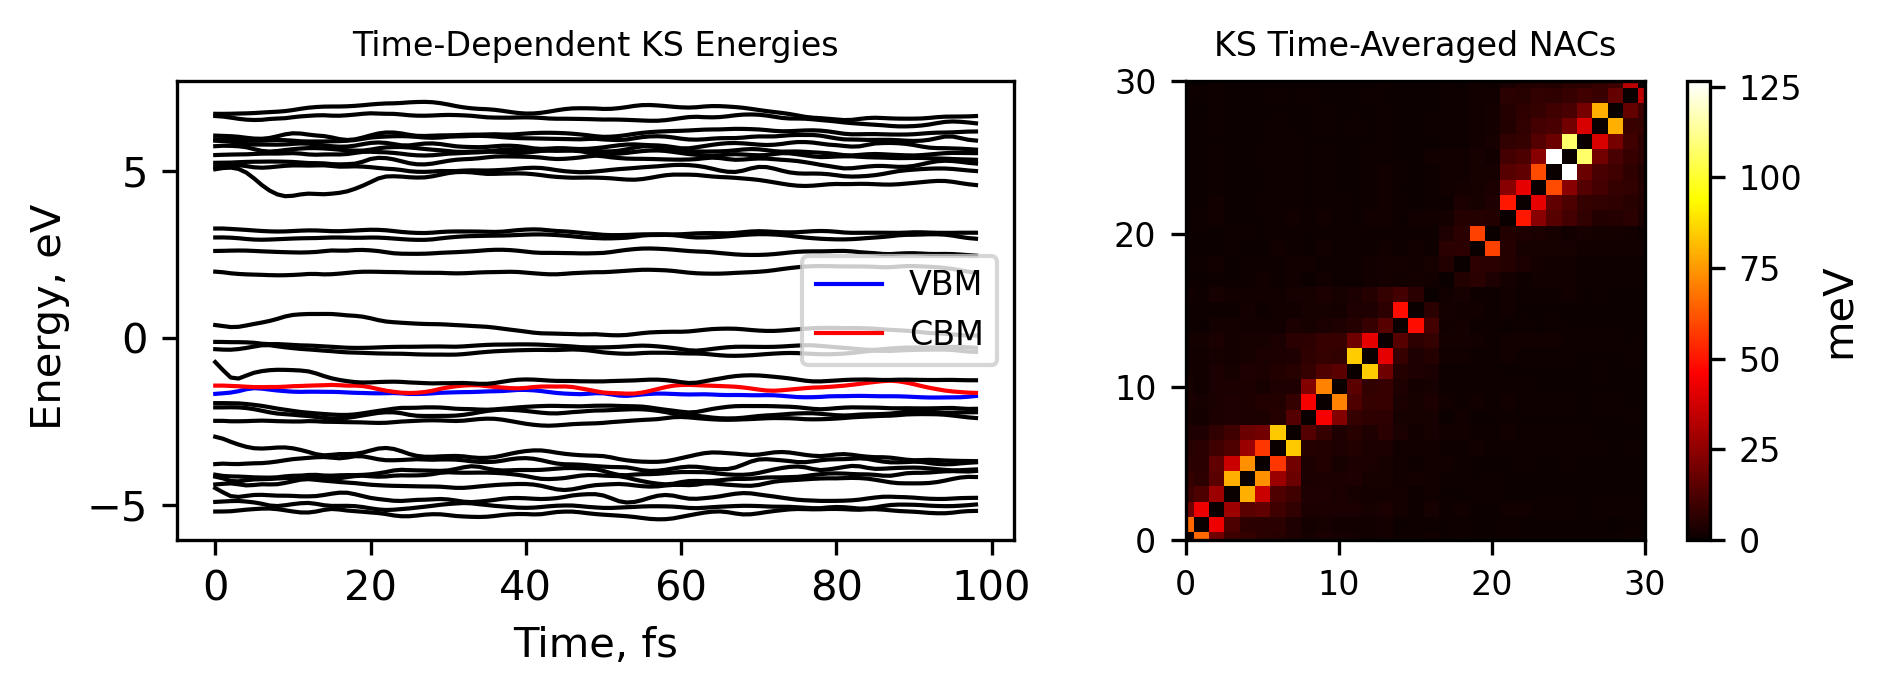

In [10]:
KS_energy = np.array( KS_energy  )
ks_tNACs  = np.array(ks_tNACs)
plt.figure(num=None, figsize=(6.42, 2.42), dpi=300, edgecolor='black', frameon=True)
plt.subplot(1,2,1)
plt.title('Time-Dependent KS Energies', fontsize=8)
plt.xlabel('Time, fs')
plt.ylabel('Energy, eV ')
for ks_index in ks_orbs_to_print:
    if ks_index == 11:
        plt.plot(md_time, KS_energy[ks_index]/units.ev2Ha, label="VBM", linewidth=1, color = "blue")
    elif ks_index == 12:
        plt.plot(md_time, KS_energy[ks_index]/units.ev2Ha, label="CBM", linewidth=1, color = "red")
    else:
        plt.plot(md_time, KS_energy[ks_index]/units.ev2Ha, label="", linewidth=1, color = "black")
plt.legend(fontsize=8)
plt.tight_layout()

plt.subplot(1,2,2)
plt.title('KS Time-Averaged NACs', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0,num_alpha_ks_orbs-1)
plt.ylim(0,num_alpha_ks_orbs-1)
# plt.xticks([0,1,2,3,4,5,6,7,8,9])
# plt.yticks([0,1,2,3,4,5,6,7,8,9])
plt.imshow(ks_tNACs, cmap='hot', interpolation='nearest')
cb = plt.colorbar(label="meV")
cb.ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()